# WSDM Cup 2025 - Explainatory Data Analysis + Feature Engineering

In this notebook we get data from the kaggle web site. Those are inputs given to train a model for the competition.  
We are going to clean and shape those data for our usage.  
We might also apply some feature engineering.  
We might also 'augment' those data by adding similar data from another competition.  
Then we save them on csv format. 

In [1]:
import sklearn

import numpy as np 
import pandas as pd
from tqdm import tqdm
import json

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.model_selection import train_test_split

import ModelsUtils as Utils

import warnings
warnings.filterwarnings("ignore")

# Config

In [2]:
MINI_RUN = False
sample_size = 0.01      # Only applied if MINI_RUN is t
seed = 707
ORIGINAL = False

----------------------------------------------------------------------

# Files

In [3]:
df_trainO = pd.read_parquet('../Data/Original/wsdm-cup-multilingual-chatbot-arena/train.parquet', engine='pyarrow') # original

In [4]:
df_trainO.head(2)

,id,prompt,response_a,response_b,winner,model_a,model_b,language
0,00007cff95d7f7974642a785aca248b0f26e60d3312fac...,vieš po Slovensky?,"Áno, hovorím po slovensky. Ako vám môžem pomôcť?","Áno, veď som tu! Môžem ti pomôcť s otázkami al...",model_a,o1-preview,reka-core-20240904,Slovak
1,00010ed04b536f56ebe43eef1100c13906abea12bf9855...,You will be given a piece of news. Analyze it ...,Let's break down the news and analyze it accor...,"```json\n{\n ""contains_orgs"": true,\n ""orgs""...",model_a,gemma-2-27b-it,gemini-1.5-flash-002,Russian


# Add data from previous competition

In [5]:
df_previous = pd.read_csv('../Data/Previous/train_preprocessed_full.csv')

df_previous = df_previous[['id', 'prompt', 'response_a', 'response_b', 'winner_model_a', 'winner_model_b', 'winner_tie']]

df_previous.shape

(57477, 7)

In [6]:
df_previous.head(1)

,id,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,Is it morally right to try to have a certain p...,NaN,"As an AI, I don't have personal beliefs or opi...",1,0,0


### remove nans

In [7]:
df_previous.isnull().sum()

id                  0
prompt            136
response_a        412
response_b        394
winner_model_a      0
winner_model_b      0
winner_tie          0
dtype: int64

In [8]:
df_previous.dropna(inplace=True)
df_previous.shape

(56788, 7)

### Remove tie

In [9]:
df_previous = df_previous[df_previous['winner_tie']==0]

In [10]:
df_previous.shape

(39209, 7)

### Duplicates

In [11]:
df_previous.drop_duplicates(subset=['id'], keep='first', inplace=True)

In [12]:
df_previous.shape

(39209, 7)

### Format

In [13]:
def winner_name(winner_b):
    if winner_b == 1:
        return 'model_b'
    else :
        return 'model_a'
df_previous['winner'] = df_previous['winner_model_b'].apply(winner_name)

In [14]:
df_previous.drop('winner_model_a', axis=1, inplace=True)
df_previous.drop('winner_model_b', axis=1, inplace=True)
df_previous.drop('winner_tie', axis=1, inplace=True)

In [15]:
df_previous.head(1)

,id,prompt,response_a,response_b,winner
1,53567,What is the difference between marriage licens...,A marriage license is a legal document that al...,A marriage license and a marriage certificate ...,model_b


### Rename columns

In [16]:
df_previous.rename(columns={'':''}, inplace=True)

### Merged

In [17]:
merged = pd.concat([df_previous, df_trainO], join='outer') 
merged

,id,prompt,response_a,response_b,winner,model_a,model_b,language
1,53567,What is the difference between marriage licens...,A marriage license is a legal document that al...,A marriage license and a marriage certificate ...,model_b,NaN,NaN,NaN
3,96401,How can I create a test set for a very rare ca...,Creating a test set for a very rare category c...,When building a classifier for a very rare cat...,model_a,NaN,NaN,NaN
4,198779,What is the best way to travel from Tel-Aviv t...,The best way to travel from Tel Aviv to Jerusa...,The best way to travel from Tel-Aviv to Jerusa...,model_b,NaN,NaN,NaN
5,292873,"Construct a rap battle, in the style of Epic R...","[Zeus]\nYo, it's the king of the gods on the m...","(Verse 1 - Zeus)\n\nI'm the king of the gods, ...",model_b,NaN,NaN,NaN
6,313413,Why water is not used in bath tub?,Water is actually used in a bath tub. A bath t...,Water is not used in a bath tub because it is ...,model_a,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
48434,fff5962462043091a771018e37ece11c425e9c7cca64b2...,你好，请你介绍下你自己,你好！我是LSK，一个形式为人工智能的chatbot。,### 介绍\n\n我是一款人工智能语言模型，基于深度学习技术开发而成。我的主要功能是理解自...,model_b,llama-3.2-3b-instruct,llama-3.1-8b-instruct,Chinese
48435,fffad6c95fb82e3a694b4952965852130285e0a38905d5...,Viva Technology参展费用,Viva Technology是一个国际性的科技展览会，每年在法国巴黎举行。参展费用会根据多...,我无法找到Viva Technology参展费用的具体公开信息。\n\n**参展费用通常取决...,model_a,reka-core-20240904,gemini-1.5-flash-exp-0827,English
48436,fffbf502f2cd88b706a4bd6e54ed90e9a2d59d1643140d...,다음은 '사무장병원 경찰 조사 동행기 - 장효강 변호사의 현장 이야기'라는 제목의 ...,"사무장병원 경찰 조사 동행기 - 장효강 변호사의 현장 이야기\n\n**""압수수색, ...","도입부를 개선하기 위해서는 독자의 관심을 더 끌어야 하며, 좀 더 명료하고 간결하게...",model_a,gemini-1.5-pro-002,yi-lightning-lite,Korean
48437,fffd2ffdaa03e9e0a0cd1e8f2ee80f530bb19b08fa4312...,What is the height of the church located in Sa...,**Church Information: Église de Saint-Nazaire-...,I couldn't find any information about a church...,model_a,llama-3.1-70b-instruct,llama-3.2-3b-instruct,English


In [18]:
merged.drop_duplicates(subset=['id'], keep='first', inplace=True)
merged

,id,prompt,response_a,response_b,winner,model_a,model_b,language
1,53567,What is the difference between marriage licens...,A marriage license is a legal document that al...,A marriage license and a marriage certificate ...,model_b,NaN,NaN,NaN
3,96401,How can I create a test set for a very rare ca...,Creating a test set for a very rare category c...,When building a classifier for a very rare cat...,model_a,NaN,NaN,NaN
4,198779,What is the best way to travel from Tel-Aviv t...,The best way to travel from Tel Aviv to Jerusa...,The best way to travel from Tel-Aviv to Jerusa...,model_b,NaN,NaN,NaN
5,292873,"Construct a rap battle, in the style of Epic R...","[Zeus]\nYo, it's the king of the gods on the m...","(Verse 1 - Zeus)\n\nI'm the king of the gods, ...",model_b,NaN,NaN,NaN
6,313413,Why water is not used in bath tub?,Water is actually used in a bath tub. A bath t...,Water is not used in a bath tub because it is ...,model_a,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
48434,fff5962462043091a771018e37ece11c425e9c7cca64b2...,你好，请你介绍下你自己,你好！我是LSK，一个形式为人工智能的chatbot。,### 介绍\n\n我是一款人工智能语言模型，基于深度学习技术开发而成。我的主要功能是理解自...,model_b,llama-3.2-3b-instruct,llama-3.1-8b-instruct,Chinese
48435,fffad6c95fb82e3a694b4952965852130285e0a38905d5...,Viva Technology参展费用,Viva Technology是一个国际性的科技展览会，每年在法国巴黎举行。参展费用会根据多...,我无法找到Viva Technology参展费用的具体公开信息。\n\n**参展费用通常取决...,model_a,reka-core-20240904,gemini-1.5-flash-exp-0827,English
48436,fffbf502f2cd88b706a4bd6e54ed90e9a2d59d1643140d...,다음은 '사무장병원 경찰 조사 동행기 - 장효강 변호사의 현장 이야기'라는 제목의 ...,"사무장병원 경찰 조사 동행기 - 장효강 변호사의 현장 이야기\n\n**""압수수색, ...","도입부를 개선하기 위해서는 독자의 관심을 더 끌어야 하며, 좀 더 명료하고 간결하게...",model_a,gemini-1.5-pro-002,yi-lightning-lite,Korean
48437,fffd2ffdaa03e9e0a0cd1e8f2ee80f530bb19b08fa4312...,What is the height of the church located in Sa...,**Church Information: Église de Saint-Nazaire-...,I couldn't find any information about a church...,model_a,llama-3.1-70b-instruct,llama-3.2-3b-instruct,English


In [19]:
if ORIGINAL:
    df_train = df_trainO
else:
    df_train = merged

In [20]:
df_train.shape

(48439, 8)

### Sample

In [21]:
if MINI_RUN:
    df_train = df_train.sample(frac=sample_size, random_state=seed)

### Clean

In [22]:
#df_train["prompt"] = df_train.prompt.map(lambda x: ''.join(eval(x.replace("null","''"))))
#df_train["response_a"] = df_train.response_a.map(lambda x: ''.join(eval(x.replace("null","''"))))
#df_train["response_b"] = df_train.response_b.map(lambda x: ''.join(eval(x.replace("null", "''"))))

In [23]:
#def process_text(text: str) -> str:
#    return "".join(eval(text, {"null": ""}))
#
#df_train.loc[:, 'prompt'] = df_train['prompt'].apply(process_text)
#df_train.loc[:, 'response_a'] = df_train['response_a'].apply(process_text)
#df_train.loc[:, 'response_b'] = df_train['response_b'].apply(process_text)
#
#display(df_train.head(5))

In [24]:
df_train['prompt'] = df_train['prompt'].astype(str)
df_train['response_a'] = df_train['response_a'].astype(str)
df_train['response_b'] = df_train['response_b'].astype(str)

### Force encoding UTF-8

In [25]:
df_train = df_train.apply(Utils.reencode, axis=1)  # Apply the make_pairs function to each row in df

In [26]:
df_train.encode_fail.value_counts(normalize=False)

encode_fail
False    48439
Name: count, dtype: int64

### One Hot

In [27]:
# Label conversion One Hot
df_train["class_label"] = df_train.winner.map(Utils.name2label)

In [28]:
df_train.head(3)

,id,prompt,response_a,response_b,winner,model_a,model_b,language,encode_fail,class_label
0,00007cff95d7f7974642a785aca248b0f26e60d3312fac...,vieš po Slovensky?,"Áno, hovorím po slovensky. Ako vám môžem pomôcť?","Áno, veď som tu! Môžem ti pomôcť s otázkami al...",model_a,o1-preview,reka-core-20240904,Slovak,False,0
1,00010ed04b536f56ebe43eef1100c13906abea12bf9855...,You will be given a piece of news. Analyze it ...,Let's break down the news and analyze it accor...,"```json\n{\n ""contains_orgs"": true,\n ""orgs""...",model_a,gemma-2-27b-it,gemini-1.5-flash-002,Russian,False,0
2,0003800d510e38803efba5ceaec122bc66408fe367b0be...,"Dört basamaklı, rakamları birbirinden ve sıfır...","Bu soruyu çözmek için, verilen koşulları adım ...",Bu problemi adım adım çözelim:\n\n1) ABCD - DC...,model_a,gpt-4-0125-preview,claude-3-5-sonnet-20240620,Turkish,False,0
3,00072026c68f5418ef2da238394e418ce72a534b9b22d5...,"현재 추천된 탑 3 종목인 Cabaletta Bio (CABA), Rocket Ph...","죄송하지만 저는 금융 조언을 제공할 수 없습니다. 저는 AI 모델이며, 투자 결정에...",현재 추천된 탑 3 종목에 순위를 매기기 위해서는 여러 가지 요소들을 고려해야 합니...,model_b,gemma-2-2b-it,llama-3.1-nemotron-70b-instruct,English,False,1
4,0007ce7cf6bc1b5a8f8a4669b854fb12030863c970d9dc...,Please be boring,"Alright, I'll be as boring as possible.\n\nTod...","Understood. Here is a straightforward, unadorn...",model_a,reka-flash-20240722,grok-2-2024-08-13,English,False,0
5,000b36b711dc332737c44ef8adf4f2d9dbd62d1b4394fd...,Придумай 25 новостных нерекламных заголовков\n...,1. Сапсаны на крыше Уралсиба: банк дарит Уфе м...,1. Сапсаны на крыше Уралсиба стали символом Уф...,model_b,gemini-1.5-flash-8b-exp-0827,gemini-1.5-flash-exp-0827,Russian,False,1
6,000b4b0dfcaf7dd8bef09141e78fa15c053fa1f54661ca...,"매체의 대역폭이 12,000Hz이고, 두 반송파 사이의 간격이 최소 2,000Hz가...",문제를 해결하기 위해 주어진 정보를 정리해 보겠습니다.\n\n- 매체의 대역폭: 1...,FSK(Frequency Shift Keying) 신호의 최대 비트율을 구하기 위해...,model_a,claude-3-opus-20240229,claude-3-haiku-20240307,Korean,False,0
7,000b677bd5e1db443ecbee1e1b6c73cf04f57efd85f452...,Utför gausselimination så vi får fram variabel...,"Självklart, låt oss lösa systemet av ekvatione...",Gausselimination är en metod för att lösa syst...,model_a,reka-core-20240904,gpt-4o-2024-08-06,Swedish,False,0
8,000c732bc38d68ed512846b748084c89f1b264ce2fa7be...,"Hãy viết cho tôi về khung cảnh xung quanh, điể...","## Trường Đại học Thủ Dầu Một: Khung cảnh, Điể...",**Khung cảnh xung quanh và điểm độc đáo của tr...,model_b,gemini-1.5-pro-002,llama-3.1-70b-instruct,Vietnamese,False,1
9,000fcb4fc8718b5a25d15978dd9979ee8601209910a58c...,Я хочу сказать другу свое окончательное решени...,"Чтобы clearly указать другу, что ты не планиру...",Можно добавить в конец сообщения фразу вроде:\...,model_a,yi-lightning,claude-3-5-sonnet-20241022,Russian,False,0


### Check Empty

### Duplicates

In [29]:
df_train[df_train.duplicated(['id'], keep=False)]

,id,prompt,response_a,response_b,winner,model_a,model_b,language,encode_fail,class_label


### Minimum length

Maybe better to check minimum number of token instead ?

#### Add length

In [30]:
for col in ["prompt", "response_a", "response_b"]:
    df_train[f"{col}_len"] = df_train[f"{col}"].str.len()

#### Check

In [31]:
for col in ["prompt", "response_a", "response_b"]:
    df_filtered = df_train.loc[df_train[f"{col}_len"] <= 10]

In [32]:
df_filtered.shape[0]

176

----------------------------------------------------------------------

# EDA

In [33]:
sns.set(style='darkgrid')

In [34]:
df_train.shape

(48439, 13)

### Distribution of LLMs

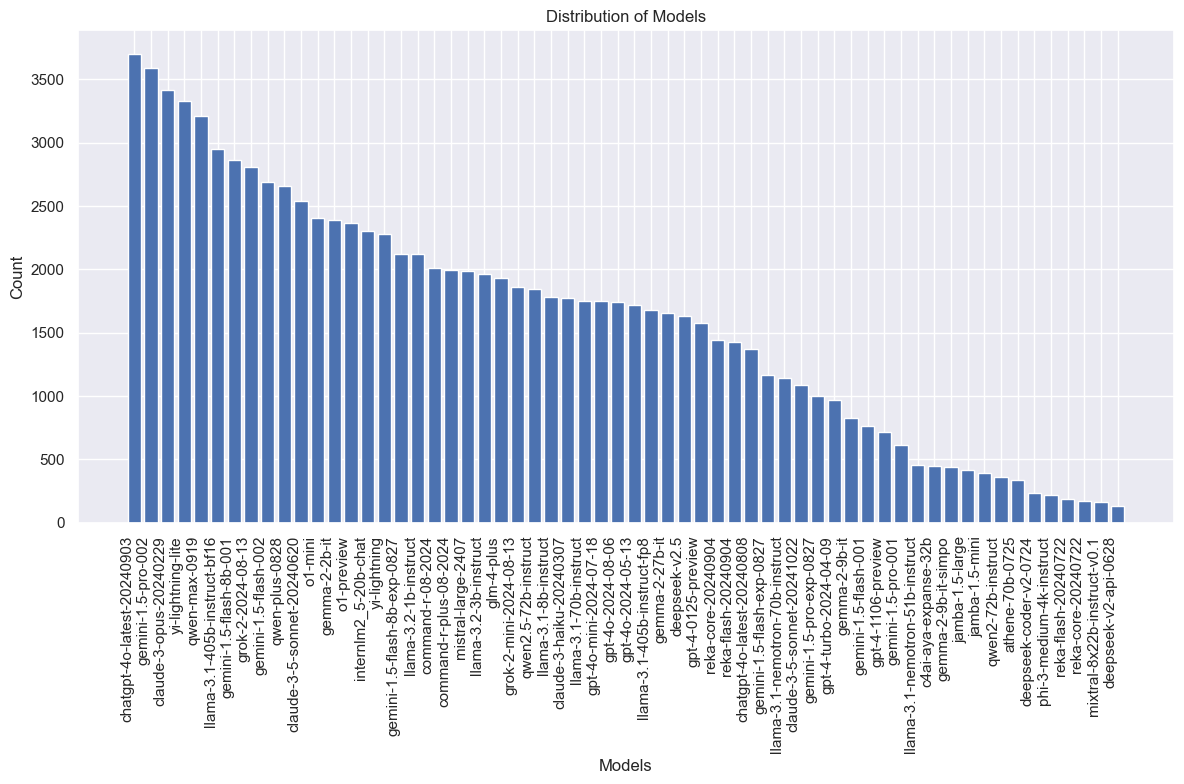

In [35]:
# Count the occurrences of each model in 'model_a'
model_df = pd.concat([df_train.model_a, df_train.model_b])

counts = model_df.value_counts().reset_index()
counts.columns = ['LLM', 'Count']

# Create the bar chart
plt.figure(figsize=(12, 8))  # Adjust figure size as needed
plt.bar(counts['LLM'], counts['Count'])
plt.xlabel('Models')
plt.ylabel('Count')
plt.title('Distribution of Models')
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

### Distribution of languages

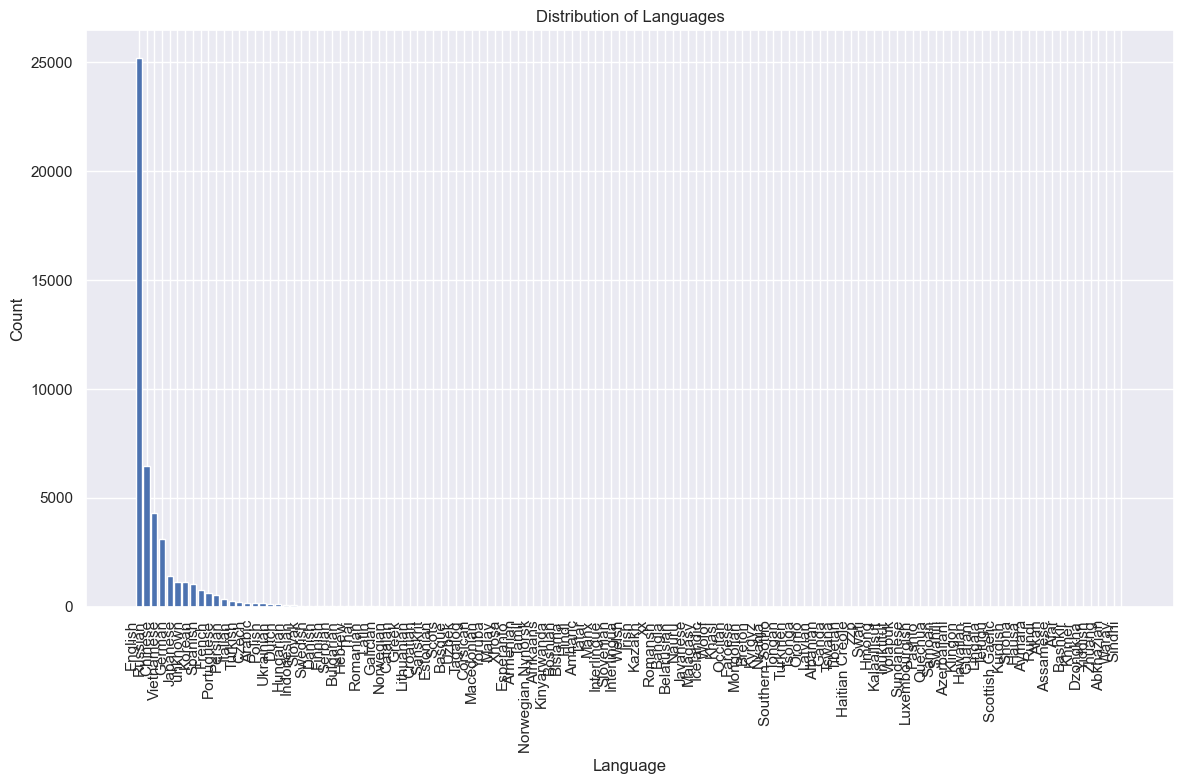

In [36]:
model_df = df_train['language']

counts = model_df.value_counts().reset_index()
counts.columns = ['Language', 'Count']

# Create the bar chart
plt.figure(figsize=(12, 8))  # Adjust figure size as needed
plt.bar(counts['Language'], counts['Count'])
plt.xlabel('Language')
plt.ylabel('Count')
plt.title('Distribution of Languages')
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

### Winner Distribution

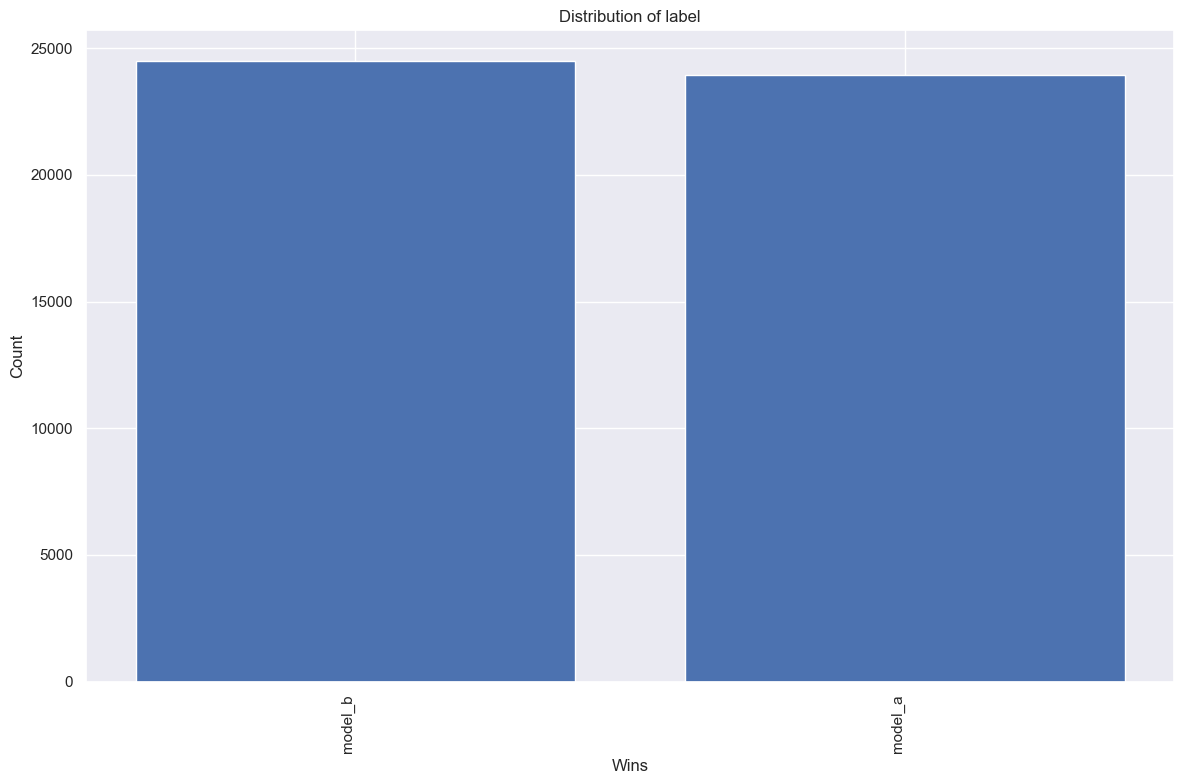

In [37]:
model_df = df_train['winner']

counts = model_df.value_counts().reset_index()
counts.columns = ['Language', 'Count']

# Create the bar chart
plt.figure(figsize=(12, 8))  # Adjust figure size as needed
plt.bar(counts['Language'], counts['Count'])
plt.xlabel('Wins')
plt.ylabel('Count')
plt.title('Distribution of label')
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

swap a/b to have perfect match between the 2 and avoid any possible position bias ?

### Distribution of length

(todo: do boxplot)

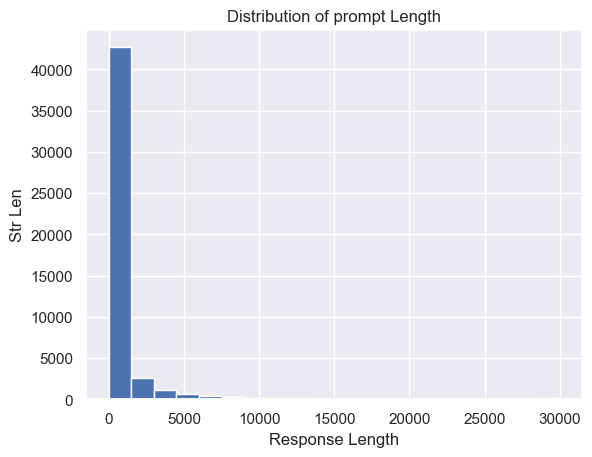

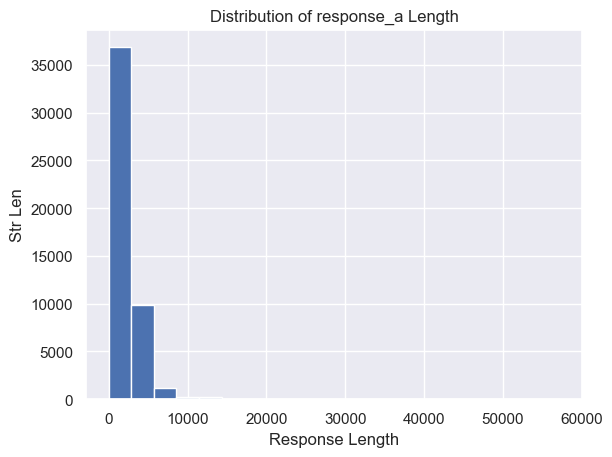

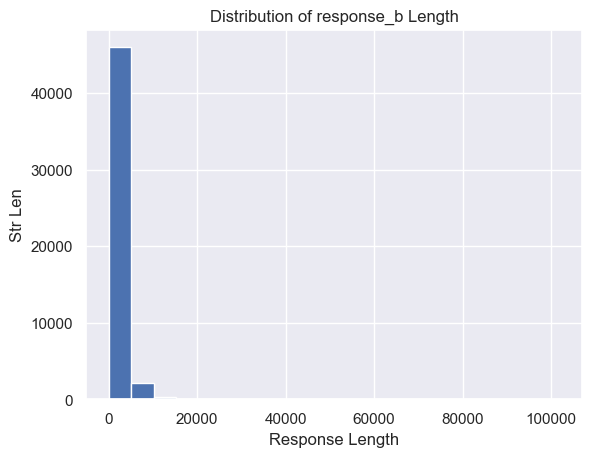

In [38]:
for col in ["prompt", "response_a", "response_b"]:
    plt.hist(df_train[f"{col}_len"], bins=20)
    plt.xlabel('Response Length')
    plt.ylabel('Str Len')
    plt.title(f'Distribution of {col} Length')
    plt.show()

# Feature Engineering

In [39]:
df_train.drop('model_a', axis=1, inplace=True)
df_train.drop('model_b', axis=1, inplace=True)
#df_train.drop('language', axis=1, inplace=True)
df_train.drop('encode_fail', axis=1, inplace=True)

### Add sentiment polarity (with TextBlob)

### Add cosine similarity

In [40]:
#df = add_computed_feats(df)
#df = add_sentiment_polarity(df)
#df = add_cosine_similarity(df)

df_train = Utils.extract_all_features(df_train)

Error processing document 727: empty vocabulary; perhaps the documents only contain stop words
Error processing document 1345: empty vocabulary; perhaps the documents only contain stop words
Error processing document 3289: empty vocabulary; perhaps the documents only contain stop words
Error processing document 3907: empty vocabulary; perhaps the documents only contain stop words
Error processing document 5182: empty vocabulary; perhaps the documents only contain stop words
Error processing document 6770: empty vocabulary; perhaps the documents only contain stop words
Error processing document 7439: empty vocabulary; perhaps the documents only contain stop words
Error processing document 7630: empty vocabulary; perhaps the documents only contain stop words
Error processing document 10565: empty vocabulary; perhaps the documents only contain stop words
Error processing document 12292: empty vocabulary; perhaps the documents only contain stop words
Error processing document 13813: empty 

In [41]:
df_train.head(2)

,id,prompt,response_a,response_b,winner,language,class_label,prompt_len,response_a_len,response_b_len,...,prompt_chinese,prompt_round_balance,prompt_curly_balance,prompt_json,prompt_sentiment,response_a_sentiment,response_b_sentiment,cosine_similarity_a,cosine_similarity_b,cosine_similarity_diff
0,00007cff95d7f7974642a785aca248b0f26e60d3312fac...,vieš po Slovensky?,"Áno, hovorím po slovensky. Ako vám môžem pomôcť?","Áno, veď som tu! Môžem ti pomôcť s otázkami al...",model_a,Slovak,0,18,48,194,...,0.0,0,0,0,0.000000,0.00000,0.00,0.816497,0.000000,0.816497
1,00010ed04b536f56ebe43eef1100c13906abea12bf9855...,You will be given a piece of news. Analyze it ...,Let's break down the news and analyze it accor...,"```json\n{\n ""contains_orgs"": true,\n ""orgs""...",model_a,Russian,0,2838,1414,183,...,0.0,0,0,1,0.055303,0.00793,-0.26,0.504042,0.213789,0.290253


### check nans

In [46]:
df_train.isnull().T.any().sum()

0

# Swap a/b (used for multithreaded trainning DDP)

In [42]:
swapped = df_train.copy()

In [43]:
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = df[col1].values, df[col2].values
    df[col1] = y
    df[col2] = x

swap_columns(swapped, f'response_a', f'response_b')

for feat in Utils.feature_list_bycol:
    swap_columns(swapped, f'response_a{feat}', f'response_b{feat}')

swap_columns(swapped, f'cosine_similarity_a', f'cosine_similarity_b')
swapped['cosine_similarity_diff'] = swapped['cosine_similarity_diff'] * -1
swapped['class_label'] = abs(swapped['class_label'] - 1)

def swap_winner(winner):
    if winner=='model_b':
        return 'model_a'
    elif winner=='model_a':
        return 'model_b'

swapped['winner'] = swapped['winner'].apply(swap_winner)

swapped.head(2)

,id,prompt,response_a,response_b,winner,language,class_label,prompt_len,response_a_len,response_b_len,...,prompt_chinese,prompt_round_balance,prompt_curly_balance,prompt_json,prompt_sentiment,response_a_sentiment,response_b_sentiment,cosine_similarity_a,cosine_similarity_b,cosine_similarity_diff
0,00007cff95d7f7974642a785aca248b0f26e60d3312fac...,vieš po Slovensky?,"Áno, veď som tu! Môžem ti pomôcť s otázkami al...","Áno, hovorím po slovensky. Ako vám môžem pomôcť?",model_b,Slovak,1,18,194,48,...,0.0,0,0,0,0.000000,0.00,0.00000,0.000000,0.816497,-0.816497
1,00010ed04b536f56ebe43eef1100c13906abea12bf9855...,You will be given a piece of news. Analyze it ...,"```json\n{\n ""contains_orgs"": true,\n ""orgs""...",Let's break down the news and analyze it accor...,model_b,Russian,1,2838,183,1414,...,0.0,0,0,1,0.055303,-0.26,0.00793,0.213789,0.504042,-0.290253


# Save CSV

In [44]:
runType = "MINI" if MINI_RUN else "FULL"
original = "original" if ORIGINAL else "custom"


df_train.to_csv(f'../Data/Preprocessed/train_preprocessed_{runType}_{original}.csv', index = False)
swapped.to_csv(f'../Data/Preprocessed/train_preprocessed_swapped_{runType}_{original}.csv', index = False)

# Only English

In [45]:
df_en = df_train[df_train['language'] == 'English']
df_en.to_csv(f'../Data/Preprocessed/train_preprocessed_{runType}_EN.csv', index = False)
df_en_swap = swapped[swapped['language'] == 'English']
df_en_swap.to_csv(f'../Data/Preprocessed/train_preprocessed_swapped_{runType}_EN.csv', index = False)